<a href="https://colab.research.google.com/github/AnzenKodo/pen/blob/main/notebooks/emotion_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
# @title Install Packages
!pip3 install -q tensorflow==2.13.0 keras==2.13.1 numpy==1.23.5 sklearn pandas==1.5.3 opencv-python==4.8.0.76

In [32]:
# @title Donload training model and other important stuff
!curl https://raw.githubusercontent.com/gitshanks/fer2013/master/fer.h5 -o fer.h5
!curl https://raw.githubusercontent.com/gitshanks/fer2013/master/fer.json -o fer.json
!curl https://raw.githubusercontent.com/gitshanks/fer2013/master/haarcascade_frontalface_default.xml -o haarcascade_frontalface_default.xml
!curl https://raw.githubusercontent.com/gitshanks/fer2013/master/test.jpg -o photo.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 22.6M  100 22.6M    0     0  72.2M      0 --:--:-- --:--:-- --:--:-- 72.4M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 12330  100 12330    0     0  87767      0 --:--:-- --:--:-- --:--:-- 88071
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  908k  100  908k    0     0  2667k      0 --:--:-- --:--:-- --:--:-- 2671k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  8536  100  8536    0     0  42986      0 --:--:-- --:--:-- --:--:-- 43111


In [ ]:
# @title Capture image
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

Loaded model from disk
Image Loaded
1/1 [==============================] - 0s 285ms/step
Emotion: Happy


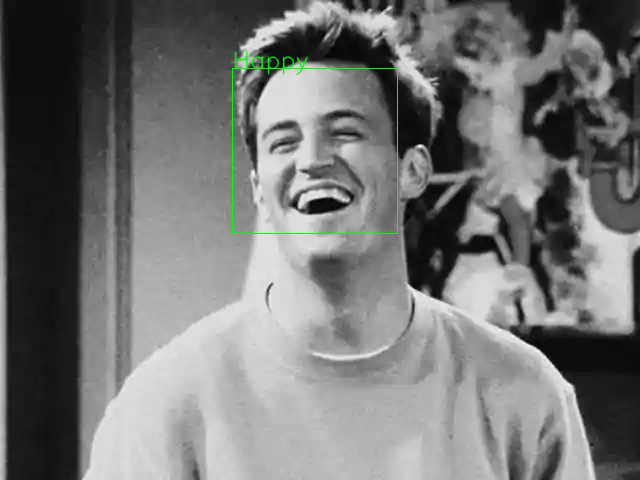

-1

In [33]:
# @title Genrate Image
from __future__ import division
from keras.models import Sequential
from keras.layers import Dense
from keras.models import model_from_json
import numpy
import os
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

#loading the model
json_file = open('fer.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("fer.h5")
print("Loaded model from disk")

#setting image resizing parameters
WIDTH = 48
HEIGHT = 48
x=None
y=None
labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

#loading image
full_size_image = cv2.imread("photo.jpg")
print("Image Loaded")
gray=cv2.cvtColor(full_size_image,cv2.COLOR_RGB2GRAY)
face = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
faces = face.detectMultiScale(gray, 1.3  , 10)

#detecting faces
for (x, y, w, h) in faces:
        roi_gray = gray[y:y + h, x:x + w]
        cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray, (48, 48)), -1), 0)
        cv2.normalize(cropped_img, cropped_img, alpha=0, beta=1, norm_type=cv2.NORM_L2, dtype=cv2.CV_32F)
        cv2.rectangle(full_size_image, (x, y), (x + w, y + h), (0, 255, 0), 1)
        #predicting the emotion
        yhat= loaded_model.predict(cropped_img)
        cv2.putText(full_size_image, labels[int(np.argmax(yhat))], (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 1, cv2.LINE_AA)
        print("Emotion: "+labels[int(np.argmax(yhat))])

cv2_imshow(full_size_image)
cv2.waitKey()